In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In [2]:
# circuit constants
Co = 1e-15 # 1 fF
Vo = 1 # 1 V reset
Qo = Co * Vo
No = Qo / 1.602e-19

# graph time scale, to us
Tf = 150
Iscale = 1e-9 # nA = 1 fC / us
Qscale = Iscale * 1e-6
MinResetTime = 1 / 30 # single clock cycle of Digital ASIC
times = np.arange(0, Tf, MinResetTime)
IMax = Qo / MinResetTime 

# function building for input charge
fnc = lambda x: 0.2 * np.sin(4*2*np.pi*x/Tf) + 0.2
x = [fnc(t) for t in times]

def inter(fnc, a, b):
    """
    integrate the current
    """
    return integrate.quad(fnc, a, b)[0]
y = [inter(fnc, 0, t) for t in times]
print(f"Running with Current Max: {IMax / Qscale:1.2f} nA")
print(f"Reset electrons: {No:1.2f}, Charge: {Qo*1e15:2.1f} fC")
print(f"Min Reset Time: {MinResetTime:2.3f} us")

Running with Current Max: 30.00 nA
Reset electrons: 6242.20, Charge: 1.0 fC
Min Reset Time: 0.033 us


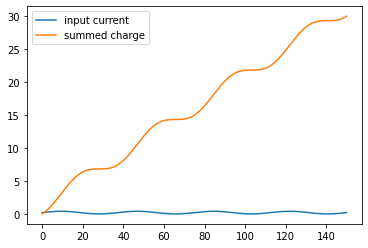

In [3]:
plt.plot(times, x, label="input current")
plt.plot(times, y, label="summed charge")
plt.legend()

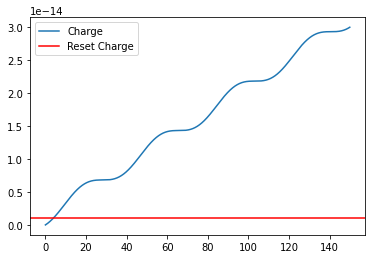

In [4]:
# make the appropriate unite conversions here to nA
charge = [j * Qscale for j in y]
# current = [i * Iscale for i in x]
voltage = [q / Co for q in charge]

# plt.plot(i, current, label="Current")
plt.plot(times, charge, label="Charge")
plt.axhline(y=Qo, c='r', label="Reset Charge")
plt.legend()

In [5]:
def countResets(times, chargeInput):
    """
    Take as input times and charge value across the capacitor
    create a series of resets to estimate the charge

    also takes as input the Qo which is the amount of resets required to happen
    for this function

    returns:
        resets - 1-d array indicating the reset time
    """

    Qout = 0
    To = -1
    resets = []
    max_resets = []

    # times should be the minimum clk cycle observed at the FPGA
    for i, (t, q) in enumerate(zip(times, chargeInput)):
        # check to make sure that we're not ahead in resets
        if To < t:
            To = t
        elif(q >= Qout + Qo): # broken time!
            max_resets.append(i)

        # empty charge out on cap if it's stored an extra Qo
        while(q >= Qout + Qo):
            To += MinResetTime
            Qout += Qo
            resets.append(To)

    if len(max_resets) > 0:
        print(f"warning exceeded max reset rate at index: {len(max_resets)}!")
    
    return resets

# create the data that the digital ASIC sees
Rs = countResets(times, charge)
Rtd = [Rs[i] - Rs[i-1] for i in range(1,len(Rs))]
print("expected resets:", int(max(charge)/Qscale))
print("received resets:", len(Rs))

expected resets: 29
received resets: 29


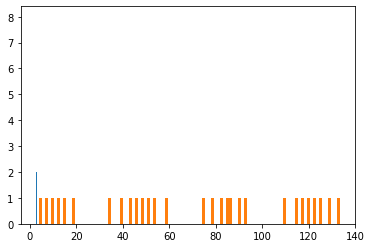

In [6]:
f = plt.hist(Rtd, bins=100)
f2 = plt.hist(Rs, bins=100)

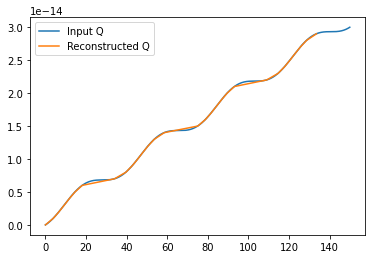

In [7]:
# reconstruct the Q here
Qsum = 0
Qr = [Qsum]
Qt = [0]
for r in Rs: 
    Qsum += Qo
    Qr.append(Qsum)
    Qt.append(r)

# reconstruct the current by taking the derivative of the CDF
plt.plot(times, charge, label="Input Q")
plt.plot(Qt, Qr, label="Reconstructed Q")
plt.legend()

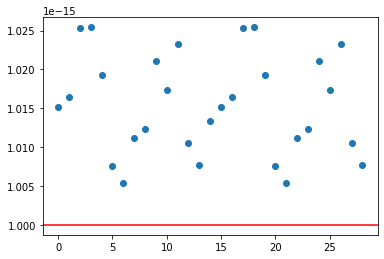

In [24]:
rmin = [np.absolute(times-r_t).argmin() for r_t in Rs]
err = [charge[r_t] - q_r for (r_t, q_r) in zip(rmin, Qr)]
plt.scatter(list(range(len(err))), err)
plt.axhline(y=Qo, c='r', label="Reset Charge")